
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.17?urlpath=lab/tree/spectrum_simulation.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/tutorials).
- **Source files:**
[spectrum_simulation.ipynb](../_static/notebooks/spectrum_simulation.ipynb) |
[spectrum_simulation.py](../_static/notebooks/spectrum_simulation.py)
</div>


# Spectrum simulation

## Prerequisites

- Knowledge of spectral extraction and datasets used in gammapy, see for instance the [spectral analysis tutorial](spectrum_analysis.ipynb)

## Context

To simulate a specific observation, it is not always necessary to simulate the full photon list. For many uses cases, simulating directly a reduced binned dataset is enough: the IRFs reduced in the correct geometry are combined with a source model to predict an actual number of counts per bin. The latter is then used to simulate a reduced dataset using Poisson probability distribution.

This can be done to check the feasibility of a measurement, to test whether fitted parameters really provide a good fit to the data etc.

Here we will see how to perform a 1D spectral simulation of a CTA observation, in particular, we will generate OFF observations following the template background stored in the CTA IRFs.

**Objective: simulate a number of spectral ON-OFF observations of a source with a power-law spectral model with CTA using the CTA 1DC response, fit them with the assumed spectral model and check that the distribution of fitted parameters is consistent with the input values.**

## Proposed approach:

We will use the following classes:

* `~gammapy.datasets.SpectrumDatasetOnOff`
* `~gammapy.datasets.SpectrumDataset`
* `~gammapy.irf.load_cta_irfs`
* `~gammapy.modeling.models.PowerLawSpectralModel`

## Setup


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.datasets import SpectrumDatasetOnOff, SpectrumDataset, Datasets
from gammapy.makers import SpectrumDatasetMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

## Simulation of a single spectrum

To do a simulation, we need to define the observational parameters like the livetime, the offset, the assumed integration radius, the energy range to perform the simulation for and the choice of spectral model. We then use an in-memory observation which is convolved with the IRFs to get the predicted number of counts. This is Poission fluctuated using the `fake()` to get the simulated counts for each observation.  

In [3]:
# Define simulation parameters parameters
livetime = 1 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-0.5, 1.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.2, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = PowerLawSpectralModel(
    index=3.0,
    amplitude=2.5e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu, name="source")

PowerLawSpectralModel

   name     value        unit      min max frozen   error  
--------- --------- -------------- --- --- ------ ---------
    index 3.000e+00                nan nan  False 0.000e+00
amplitude 2.500e-12 cm-2 s-1 TeV-1 nan nan  False 0.000e+00
reference 1.000e+00            TeV nan nan   True 0.000e+00


In [5]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

In [6]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.04
	duration          : 3600.00 s
	pointing (icrs)   : 266.4 deg, -28.9 deg

	deadtime fraction : 0.0%



In [7]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges,
    e_true=energy_axis_true.edges,
    region=on_region,
    name="obs-0",
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [8]:
# Set the model on the dataset, and fake
dataset.models = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset
---------------

  Name                            : obs-0 

  Total counts                    : 290 
  Total predicted counts          : 294.61
  Total background counts         : 22.35

  Effective area min              : 8.16e+04 m2
  Effective area max              : 5.08e+06 m2

  Livetime                        : 3.60e+03 s

  Number of total bins            : 9 
  Number of fit bins              : 9 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -1742.28

  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : None
    Temporal model type       : None
    Parameters:
      index                   :   3.000              
      amplitude               :   2.50e-12  1 / (cm2 s TeV)
      reference    (frozen)   :   1.000  TeV   

You can see that backgound counts are now simulated

### OnOff analysis

To do `OnOff` spectral analysis, which is the usual science case, the standard would be to use `SpectrumDatasetOnOff`, which uses the acceptance to fake off-counts 

In [9]:
dataset_onoff = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=dataset, acceptance=1, acceptance_off=5
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff
--------------------

  Name                            : obs-0 

  Total counts                    : 294 
  Total predicted counts          : 293.46
  Total off counts                : 106.00

  Total background counts         : 21.20

  Effective area min              : 8.16e+04 m2
  Effective area max              : 5.08e+06 m2

  Livetime                        : 3.60e+03 s

  Acceptance mean:                : 1.0

  Number of total bins            : 9 
  Number of fit bins              : 9 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.46

  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : None
    Temporal model type       : None
    Parameters:
      index                   :   3.000              
      amplitude

You can see that off counts are now simulated as well. We now simulate several spectra using the same set of observation conditions.

In [10]:
%%time

n_obs = 100
datasets = Datasets()

for idx in range(n_obs):
    dataset_onoff.fake(
        random_state=idx, background_model=dataset.background,
    )
    datasets.append(dataset_onoff.copy(name=f"obs-{idx}"))

CPU times: user 752 ms, sys: 20 ms, total: 772 ms
Wall time: 789 ms


In [11]:
print(datasets.names)

['obs-0', 'obs-1', 'obs-2', 'obs-3', 'obs-4', 'obs-5', 'obs-6', 'obs-7', 'obs-8', 'obs-9', 'obs-10', 'obs-11', 'obs-12', 'obs-13', 'obs-14', 'obs-15', 'obs-16', 'obs-17', 'obs-18', 'obs-19', 'obs-20', 'obs-21', 'obs-22', 'obs-23', 'obs-24', 'obs-25', 'obs-26', 'obs-27', 'obs-28', 'obs-29', 'obs-30', 'obs-31', 'obs-32', 'obs-33', 'obs-34', 'obs-35', 'obs-36', 'obs-37', 'obs-38', 'obs-39', 'obs-40', 'obs-41', 'obs-42', 'obs-43', 'obs-44', 'obs-45', 'obs-46', 'obs-47', 'obs-48', 'obs-49', 'obs-50', 'obs-51', 'obs-52', 'obs-53', 'obs-54', 'obs-55', 'obs-56', 'obs-57', 'obs-58', 'obs-59', 'obs-60', 'obs-61', 'obs-62', 'obs-63', 'obs-64', 'obs-65', 'obs-66', 'obs-67', 'obs-68', 'obs-69', 'obs-70', 'obs-71', 'obs-72', 'obs-73', 'obs-74', 'obs-75', 'obs-76', 'obs-77', 'obs-78', 'obs-79', 'obs-80', 'obs-81', 'obs-82', 'obs-83', 'obs-84', 'obs-85', 'obs-86', 'obs-87', 'obs-88', 'obs-89', 'obs-90', 'obs-91', 'obs-92', 'obs-93', 'obs-94', 'obs-95', 'obs-96', 'obs-97', 'obs-98', 'obs-99']


Before moving on to the fit let's have a look at the simulated observations.

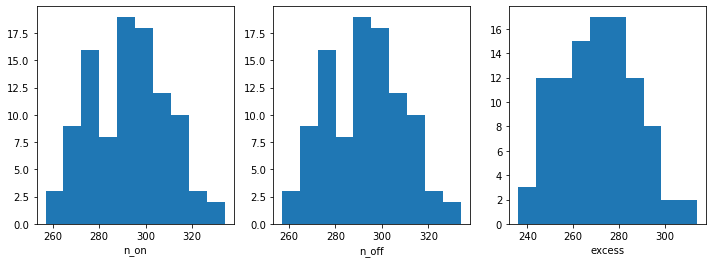

In [12]:
table = datasets.info_table()

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(table["n_on"])
axes[0].set_xlabel("n_on")
axes[1].hist(table["n_on"])
axes[1].set_xlabel("n_off")
axes[2].hist(table["excess"])
axes[2].set_xlabel("excess");

Now, we fit each simulated spectrum individually 

In [13]:
%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
        }
    )

CPU times: user 11.5 s, sys: 158 ms, total: 11.7 s
Wall time: 12.2 s


We take a look at the distribution of the fitted indices. This matches very well with the spectrum that we initially injected, index=2.1

index: 3.0073915770772874 += 0.08556246464338188


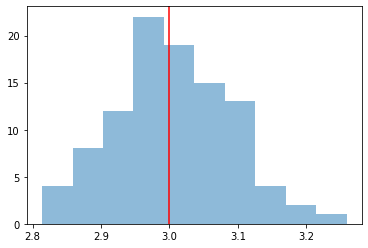

In [14]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
print(f"index: {index.mean()} += {index.std()}")

## Exercises

* Change the observation time to something longer or shorter. Does the observation and spectrum results change as you expected?
* Change the spectral model, e.g. add a cutoff at 5 TeV, or put a steep-spectrum source with spectral index of 4.0
* Simulate spectra with the spectral model we just defined. How much observation duration do you need to get back the injected parameters?